2.1.1: Setup

Importing various required modules and the MNIST dataset. Initializing randomizer.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch import Tensor, nn
from torchvision.datasets import MNIST
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.transforms import ToTensor
# Static random seed
np.random.seed(89)

# Need to convert data to Tensor, because the DataLoader iterator refuses to work with PIL image objects.
# Also experienced other trouble when having the PIL image
pil2tensor = lambda x: ToTensor()(x).squeeze()   # ToTensor return (64,1,28,28), the squeeze() call removes the 1 dimension
# Standard MNIST dataset (not binarized)
mnist_data = MNIST("./temp/", transform=pil2tensor, download=True)

Extracting ./temp/MNIST\raw\train-images-idx3-ubyte.gz to ./temp/MNIST\raw


Extracting ./temp/MNIST\raw\train-labels-idx1-ubyte.gz to ./temp/MNIST\raw


Extracting ./temp/MNIST\raw\t10k-images-idx3-ubyte.gz to ./temp/MNIST\raw


Extracting ./temp/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./temp/MNIST\raw
Processing...
Done!


C:\Users\Uffe\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


2.1.2: Plot 8x8 random samples

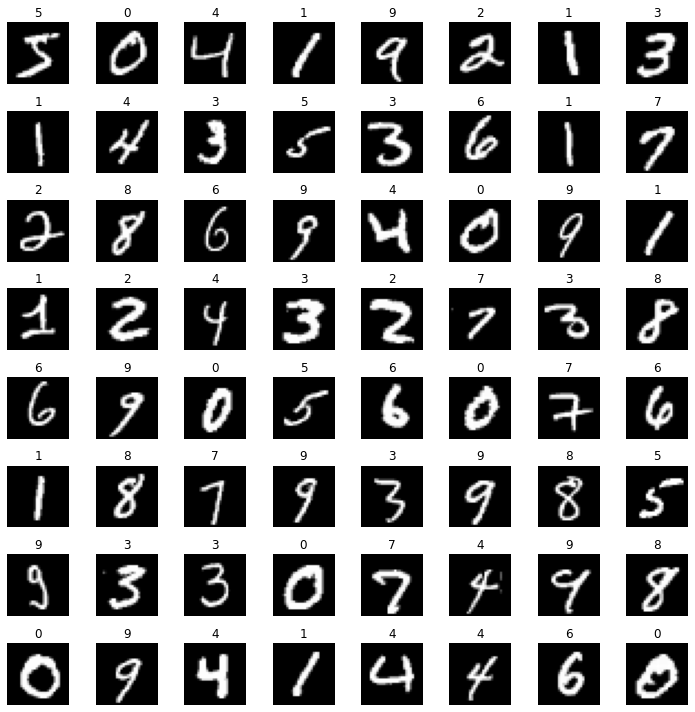

In [2]:
from torch.utils.data import DataLoader

mnist_loader = DataLoader(mnist_data, batch_size = 64)
images, labels = next(iter(mnist_loader))
fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(images[i], cmap='gray')
    ax.set_title("%s" % (labels[i].item()))
    ax.axis('off')
    i += 1
plt.tight_layout()

2.1.3: Implement dynamic binarization

Sampling binarized pixels using intensity as probability.

In [3]:
# Setup Bernoulli statistical sampling conversion from grey-scale to binary
from torchvision import transforms

# AXBR: bit wierd, I thought we would need to normalize the image to [0,1] like this:
#      transforms.Lambda(lambda x: torch.bernoulli(x.double()/255))]))
# because the MNIST image uses unsigned 8-bit, and thus have range 0-255. Does PyTorch datasets normalize when using __getitem__ ?
# When using 'data[idx]' method the data comes out raw (0-255) without the transform being performed.
# Seems the transform is only attached to the dataset, and first invoked when doing '__getitem__'.
binarized_mnist_data = MNIST("./temp/", download=True, transform=transforms.Compose([pil2tensor, 
                                                                                     transforms.Lambda(lambda x: torch.bernoulli(x))]))

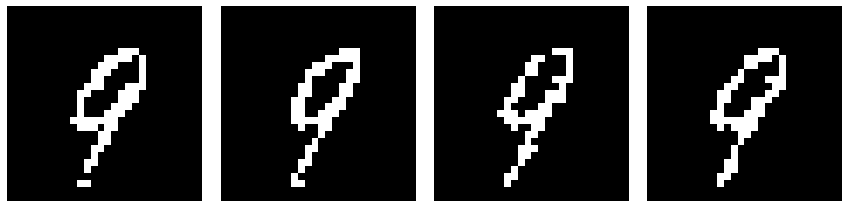

In [4]:
# Plot same image a couple of times to verify we are doing statistical sampling every time the image is drawn
fig, axs = plt.subplots(1, 4, figsize=(12, 3), squeeze=False)
for ax in axs.flat:
    sample = binarized_mnist_data.__getitem__(22)[0]
    assert torch.max(sample) == 1.0
    assert torch.min(sample) == 0.0
    ax.imshow(sample, cmap='gray')
    ax.axis('off')
plt.tight_layout()

2.1.4: Plot binarized MNIST samples

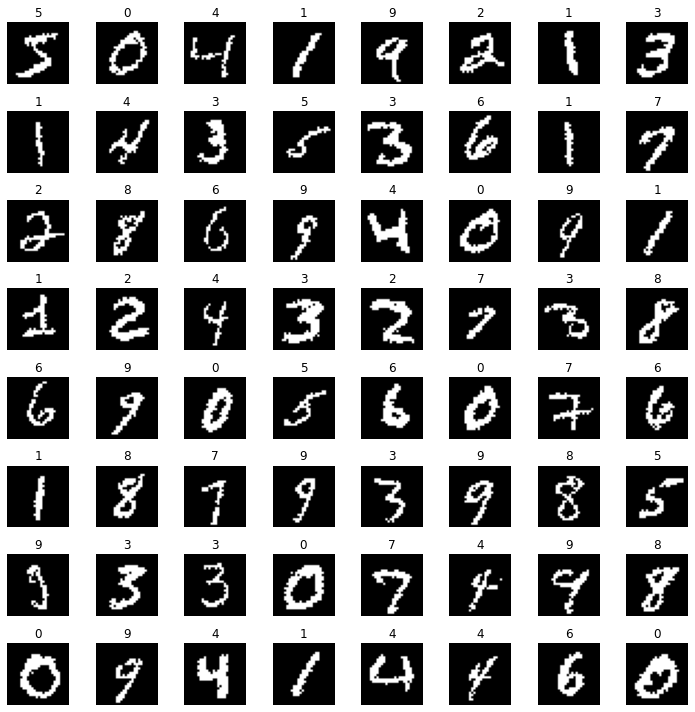

In [5]:
from torch.utils.data import DataLoader

binarized_mnist_loader = DataLoader(binarized_mnist_data, batch_size = 64)
images, labels = next(iter(binarized_mnist_loader))
fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(images[i], cmap='gray')
    ax.set_title("%s" % (labels[i].item()))
    ax.axis('off')
    i += 1
plt.tight_layout()

2.2.1.1: VAE implementation

In [6]:
# Implement reparameterized diagonal gaussian
from torch.distributions import Distribution

class ReparameterizedDiagonalGaussian(Distribution):
    def __init__(self, mu: Tensor, log_sigma: Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        return self.mu + self.sigma*self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        from torch.distributions import Normal 
        return  Normal(loc=self.mu, scale=self.sigma).log_prob(z)

In [7]:
# Return sum of values in all dimenensions, except the first one, which is assumed to be batch
def reduce(x: Tensor) -> Tensor:
    return x.view(x.size(0), -1).sum(dim=1)

In [11]:
from typing import Dict, Any

from torch.distributions import Bernoulli

# Define hidden layer topology - list of sizes of hidden layers
encoder_dimensions = [512, 256, 128]
decoder_dimensions = [128, 256, 512]
apply_per_layer_batchnorm = False

# Implement VAE
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoEncoder, self).__init__()

        # Core parameters
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        #self.prior_params = torch.zeros(torch.Size([1, 2*latent_features]))
        
        # Dynamically constructing the encoder network
        encoder_constructor = []
        encoder_constructor.append(nn.Linear(in_features=self.observation_features, out_features=encoder_dimensions[0]))
        encoder_constructor.append(nn.ReLU())
        if apply_per_layer_batchnorm:
            encoder_constructor.append(nn.BatchNorm1d(num_features=encoder_dimensions[0]))
        for i in range(len(encoder_dimensions)-1):
            encoder_constructor.append(nn.Linear(in_features=encoder_dimensions[i], out_features=encoder_dimensions[i+1]))
            encoder_constructor.append(nn.ReLU())
            if apply_per_layer_batchnorm:
                encoder_constructor.append(nn.BatchNorm1d(num_features=encoder_dimensions[i+1]))
        encoder_constructor.append(nn.Linear(in_features=encoder_dimensions[-1], out_features=2*self.latent_features))
        self.encoder = nn.Sequential(*encoder_constructor)

        # Dynamically constructing the decoder network
        decoder_constructor = []
        decoder_constructor.append(nn.Linear(in_features=self.latent_features, out_features=decoder_dimensions[0]))
        decoder_constructor.append(nn.ReLU())
        if apply_per_layer_batchnorm:
            decoder_constructor.append(nn.BatchNorm1d(num_features=decoder_dimensions[0]))
        for i in range(len(decoder_dimensions)-1):
            decoder_constructor.append(nn.Linear(in_features=decoder_dimensions[i], out_features=decoder_dimensions[i+1]))
            decoder_constructor.append(nn.ReLU())
            if apply_per_layer_batchnorm:
                decoder_constructor.append(nn.BatchNorm1d(num_features=decoder_dimensions[i+1]))
        decoder_constructor.append(nn.Linear(in_features=decoder_dimensions[-1], out_features=self.observation_features))
        self.decoder = nn.Sequential(*decoder_constructor)
    
    # Encode input into posterior distribution
    def encode(self, x: Tensor) -> Distribution:
        print(x.shape)
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    # Decode latent variables into reconstruction
    def decode(self, z: Tensor) -> Distribution:
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape)
        return Bernoulli(logits=px_logits)
    
    # Get the prior distribution
    def prior(self, batch_size: int = 1) -> Distribution:
        local_prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = local_prior_params.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    # Sample from a provided distribution
    def sample(self, distribution: ReparameterizedDiagonalGaussian) -> Tensor:
        return distribution.rsample()
    
    # Compute the ELBO
    def elbo(self, prior: Distribution, posterior: Distribution, reconstruction: Distribution, x: Tensor, z: Tensor) -> float:
        tst = reconstruction.sample()
        log_px = reduce(reconstruction.log_prob(x))
        log_pz = reduce(prior.log_prob(z))
        log_qz = reduce(posterior.log_prob(z))
        kl = log_qz - log_pz
        elbo = log_px - kl
        return elbo
    
    def forward(self, x: Tensor) -> Dict[str, Any]:
        # flatten the input
        x = x.view(x.size(0), -1)
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.encode(x)
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        # define the observation model p(x|z) = B(x | g(z))
        px = self.decode(z)
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}

In [16]:
# Instantiate a VAE
testVAE = VariationalAutoEncoder(sample.flatten().shape, 2)
print(testVAE.encoder)
print(testVAE.decoder)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=4, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=784, bias=True)
)


2.2.1.2: Print samples from untrained VAE

torch.Size([64, 784])


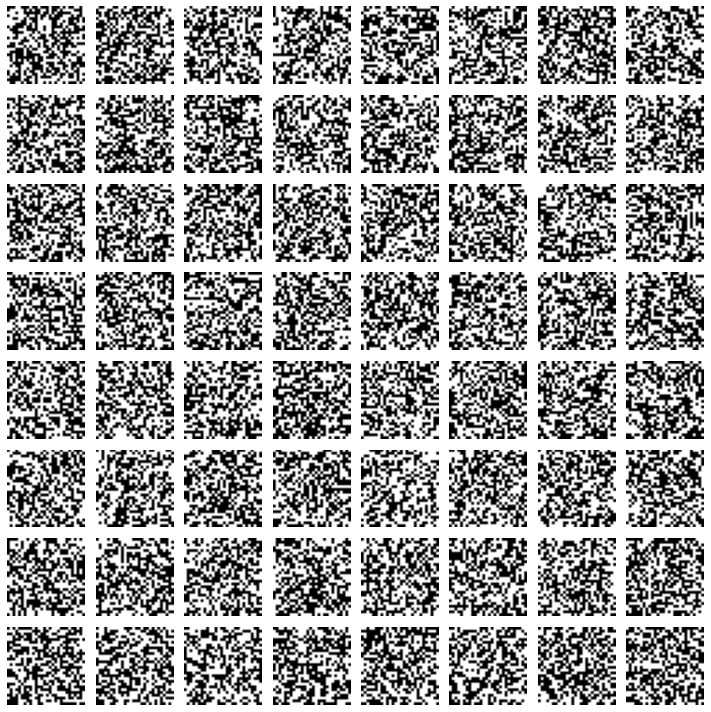

In [17]:
#testVAE.eval()

if False:
  prior = testVAE.prior(64)
  prior_sample = testVAE.sample(prior)
  decoded_prior_sample = testVAE.decode(prior_sample)
  sampled_decode_content = decoded_prior_sample.sample().view(64, 28, 28)

a = random.choices(mnist_data,k=64)
b = [x[0] for x in a]
img = torch.stack(b)
sampled_decode_content = testVAE(img)['px'].sample().view(-1,28,28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    sample = random.choice(binarized_mnist_data)
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

2.2.1.3: Compute ELBO of 64 samples

In [28]:
samples = np.zeros(shape=(64, 784))
labels = np.zeros(shape=(64, 1))
for i in range(64):
    sample = random.choice(binarized_mnist_data)
    samples[i] = sample[0].view(1, -1).numpy()
    labels[i] = sample[1]
#samples = random.choices(binarized_mnist_data,k=64)
#print(samples[0][0].shape)

prior = testVAE.prior(64)
#samples_tensor = Tensor(samples[0].view(1, -1).numpy())
samples_tensor = Tensor(samples)
posterior = testVAE.encode(samples_tensor)
z = testVAE.sample(posterior) # Random sampling
reconstruction = testVAE.decode(z)
elbo = testVAE.elbo(prior, posterior, reconstruction, samples_tensor, z) 

print("ELBO: ", elbo)

torch.Size([64, 784])
ELBO:  tensor([-544.6118, -543.6534, -544.3140, -544.9758, -545.4962, -544.2440,
        -543.2391, -543.3699, -543.5011, -544.1947, -542.6655, -542.8667,
        -542.8156, -543.1981, -544.3276, -543.5673, -544.5097, -544.5555,
        -544.7647, -545.0264, -544.6683, -544.0387, -545.1776, -543.4950,
        -543.0690, -543.2399, -543.9361, -544.1539, -543.4112, -543.9024,
        -543.7320, -543.3071, -544.8915, -544.3370, -543.4266, -543.4047,
        -543.1310, -545.1257, -544.1297, -544.8247, -545.2117, -542.5557,
        -543.5348, -543.1978, -543.8024, -544.5238, -543.8330, -545.8348,
        -543.5472, -543.8291, -544.5764, -544.0801, -544.7384, -543.6635,
        -544.6415, -543.9968, -544.1795, -543.9058, -543.9762, -543.7361,
        -545.1446, -543.8539, -544.4798, -543.5452], grad_fn=<SubBackward0>)
